# Setup the optimization problem

## Ensure path (weight vector -> loss on MNIST) is differentiable

# Train two networks

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms

import matplotlib.pyplot as plt


import lovely_tensors as lt
lt.monkey_patch()

from tqdm.auto import tqdm

In [2]:
device = 'cuda:0'
batch_size = 128
seed = 0

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Load and normalize MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Train the network
num_epochs = 3

In [3]:
import torch
import torch.nn.functional as F

def kaiming_init(tensor):
    fan_in = tensor.shape[1]
    gain = torch.nn.init.calculate_gain('relu')
    std = gain / torch.sqrt(torch.tensor(fan_in, dtype=torch.float32))
    return tensor.normal_(0, std.item())

class RawSimpleCNN5:
    def __init__(self):
        # Initialize weights and biases using Kaiming initialization
        self.W1 = kaiming_init(torch.empty(32, 1, 3, 3))
        self.b1 = torch.zeros(32)
        self.W2 = kaiming_init(torch.empty(64, 32, 3, 3))
        self.b2 = torch.zeros(64)
        self.W3 = kaiming_init(torch.empty(128, 64, 3, 3))
        self.b3 = torch.zeros(128)
        self.W4 = kaiming_init(torch.empty(256, 128, 3, 3))
        self.b4 = torch.zeros(256)
        self.W_fc1 = kaiming_init(torch.empty(10, 256))
        self.b_fc1 = torch.zeros(10)

        self.parameters = [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3, self.W4, self.b4, self.W_fc1, self.b_fc1]
        for p in self.parameters:
            p.requires_grad=True
        
        
    def to(self, *args, **kwargs):
        for i, p in enumerate(self.parameters):
            self.parameters[i] = p.to(*args, **kwargs)
        return self

    def raw_forward(self, x, params=None):
        if params is None:
            params = self.parameters

        W1, b1, W2, b2, W3, b3, W4, b4, W_fc1, b_fc1 = params

        x = F.conv2d(x, W1, b1, padding=1)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = F.conv2d(x, W2, b2, padding=1)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = F.conv2d(x, W3, b3, padding=1)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = F.conv2d(x, W4, b4, padding=1)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = x.view(-1, 256)

        x = F.linear(x, W_fc1, b_fc1)

        return x

def parameters_to_simple_cnn(params):
    model = SimpleCNN()
    model.conv1.weight.data.copy_(params[0])
    model.conv1.bias.data.copy_(params[1])
    model.conv2.weight.data.copy_(params[2])
    model.conv2.bias.data.copy_(params[3])
    model.conv3.weight.data.copy_(params[4])
    model.conv3.bias.data.copy_(params[5])
    model.conv4.weight.data.copy_(params[6])
    model.conv4.bias.data.copy_(params[7])
    model.fc1.weight.data.copy_(params[8].t())
    model.fc1.bias.data.copy_(params[9])

    return model

class RawSimpleCNN3:
    def __init__(self):
        # Initialize weights and biases using Kaiming initialization
        self.W1 = kaiming_init(torch.empty(8, 1, 3, 3))
        self.b1 = torch.zeros(8)
        self.W2 = kaiming_init(torch.empty(8, 8, 3, 3))
        self.b2 = torch.zeros(8)
        # self.W3 = kaiming_init(torch.empty(128, 64, 3, 3))
        # self.b3 = torch.zeros(128)
        # self.W4 = kaiming_init(torch.empty(256, 128, 3, 3))
        # self.b4 = torch.zeros(256)
        self.W_fc1 = kaiming_init(torch.empty(10, 392))
        self.b_fc1 = torch.zeros(10)

        self.parameters = [self.W1, self.b1, self.W2, self.b2, self.W_fc1, self.b_fc1]
        for p in self.parameters:
            p.requires_grad=True
        
        
    def to(self, *args, **kwargs):
        for i, p in enumerate(self.parameters):
            self.parameters[i] = p.to(*args, **kwargs)
        return self

    def raw_forward(self, x, params=None):
        if params is None:
            params = self.parameters

        bs = x.shape[0]
        W1, b1, W2, b2, W_fc1, b_fc1 = params

        x = F.conv2d(x, W1, b1, padding=1)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = F.conv2d(x, W2, b2, padding=1)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = x.view(bs, -1)

        x = F.linear(x, W_fc1, b_fc1)

        return x

def parameters_to_simple_cnn(params):
    model = RawSimpleCNN3()
    model.conv1.weight.data.copy_(params[0])
    model.conv1.bias.data.copy_(params[1])
    model.conv2.weight.data.copy_(params[2])
    model.conv2.bias.data.copy_(params[3])
    model.fc1.weight.data.copy_(params[4].t())
    model.fc1.bias.data.copy_(params[5])

    return model

# Test the raw_forward function
RawSimpleCNN = RawSimpleCNN3
raw_net = RawSimpleCNN().to(device)

In [4]:
import os
import random
import numpy as np
import torch

def seed_all(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
def net2params(raw_net):
    params_shapes = []
    params = []

    for p in raw_net.parameters:
        params_shapes.append( p.shape )
        params.append(p.flatten())

    param_vec = torch.cat(params)
    return param_vec, params_shapes

In [6]:
def product(li):
    p = 1
    for e in li:
        p *= e
    return p

def reconstruct_params(param_vec, params_shapes):
    offset = 0
    reconstructed_params = []

    for shape in params_shapes:
        n = product(shape)
        p = param_vec[offset:offset+n]
        p = p.reshape(shape)

        reconstructed_params.append(p)

        offset += n
        
    return reconstructed_params

In [7]:
def param_vec2net(param_vec, params_shapes):
    params = reconstruct_params
    raw_net = RawSimpleCNN()
    
    reconstructed_params = reconstruct_params(param_vec, params_shapes)
    raw_net.parameters = reconstructed_params
    return raw_net

In [8]:
def train(num_epochs=2, seed=42):
    seed=42
    seed_all(seed)
    print(f'Set seed={seed}')

    param_vec, params_shapes = net2params(RawSimpleCNN())
    param_vec = param_vec.detach().to(device)
    param_vec.requires_grad = True

    optimizer = optim.AdamW([param_vec], lr=3e-4)
    epoch_losses = []
    pbar = tqdm(range(num_epochs))

    for epoch in pbar:
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            raw_net = param_vec2net(param_vec, params_shapes)
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = raw_net.raw_forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print(loss.item())

            running_loss += loss.item()

        avg_loss = running_loss / ((i + 1))
        epoch_losses.append(avg_loss)
        pbar.set_description(f"Epoch {epoch + 1}, Loss: {avg_loss:.6f}")


    print("Training completed.")

    # Plot the training loss curve
    plt.plot(range(1, num_epochs + 1), epoch_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()

    # Test the network
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = raw_net.raw_forward(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy on the 10,000 test images: {100 * correct / total}%")
    return param_vec, params_shapes

In [9]:
seed_all(seed)

Set seed=42


  0%|          | 0/2 [00:00<?, ?it/s]

Training completed.


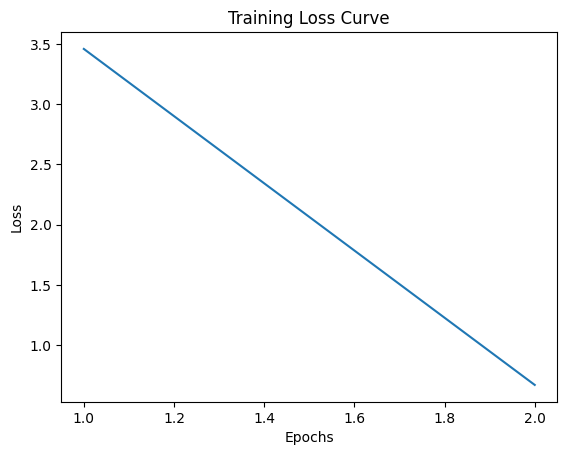

Accuracy on the 10,000 test images: 88.36%


In [10]:
param_vec2, params_shapes = train(num_epochs=2, seed=2)

Set seed=42


  0%|          | 0/5 [00:00<?, ?it/s]

Training completed.


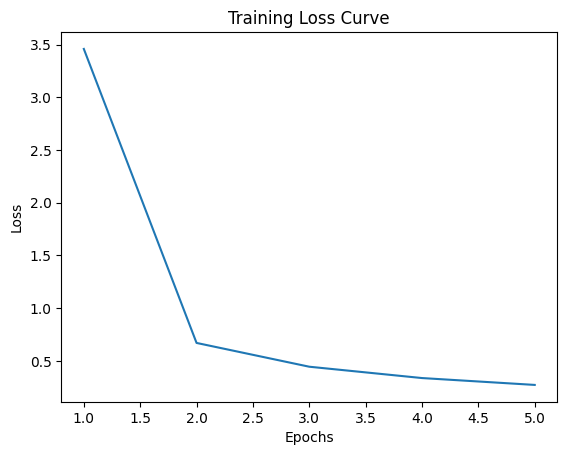

Accuracy on the 10,000 test images: 94.05%


In [11]:
param_vec3, params_shapes = train(num_epochs=5, seed=3)

In [12]:
def evaluate_loss(param_vec, verbose=False):
    loss = 0.
    n_images = 0
    correct = 0
    with torch.inference_mode():

        raw_net = param_vec2net(param_vec, params_shapes)

        for i, data in zip(range(1), testloader):
            images, labels = data

            images, labels = images.to(device), labels.to(device)
            outputs = raw_net.raw_forward(images)

            batch_loss = criterion(outputs, labels)
            loss += batch_loss

            _, predicted = torch.max(outputs.data, 1)
            # print('predicted',predicted)
            n_images += labels.size(0)
            correct += (predicted == labels).sum().item()

    if verbose:
        print(f"Loss={loss} | Accuracy on the {n_images} test images: {100 * correct / n_images}%")
    return loss

# Mode connectivity

$\phi$

In [13]:
class BezierConnectome:
    def __init__(self, w1, w2):
        self.theta = torch.randn_like(w1) * w1.std()

        self.w1 = w1
        self.w2 = w2
        
    def phi(self, t):
        return (1-t**2)*self.w1 + 2*t*(1.-t)*self.theta + t**2*self.w2

In [14]:
w2, w3 = param_vec2, param_vec3

In [15]:
connectome = BezierConnectome(w2, w3)

In [16]:
connectome.theta = connectome.theta.detach()
connectome.theta.requires_grad=True
optimizer = optim.AdamW([connectome.theta], lr=3e-4)

In [17]:
connectome.theta

tensor[4594] x∈[-0.875, 0.878] μ=0.001 σ=0.251 grad cuda:0

In [18]:
def loss_for_w(w):
    loss = 0.
    n_images = 0
    correct = 0

    raw_net = param_vec2net(w, params_shapes)

    for i, data in zip(range(1), testloader):
        images, labels = data

        images, labels = images.to(device), labels.to(device)
        outputs = raw_net.raw_forward(images)

        batch_loss = criterion(outputs, labels)
        loss += batch_loss

        _, predicted = torch.max(outputs.data, 1)
        # print('predicted',predicted)
        n_images += labels.size(0)
        correct += (predicted == labels).sum().item()
    return loss

In [19]:
def ts2loss(ts):
    ws = connectome.phi(ts)
    loss = []
    for w in ws:
        loss.append(loss_for_w(w))
    return loss

In [20]:
ts = torch.linspace(0,1, (5), device=device)[:, None]
ts

tensor[5, 1] x∈[0., 1.000] μ=0.500 σ=0.395 cuda:0 [[0.], [0.250], [0.500], [0.750], [1.000]]

In [21]:
losses = ts2loss(ts)
losses

[tensor grad AddBackward0 cuda:0 0.219,
 tensor grad AddBackward0 cuda:0 17.161,
 tensor grad AddBackward0 cuda:0 27.135,
 tensor grad AddBackward0 cuda:0 15.464,
 tensor grad AddBackward0 cuda:0 0.100]

In [22]:
loss_for_w(w2), loss_for_w(w3)

(tensor grad AddBackward0 cuda:0 0.219, tensor grad AddBackward0 cuda:0 0.100)

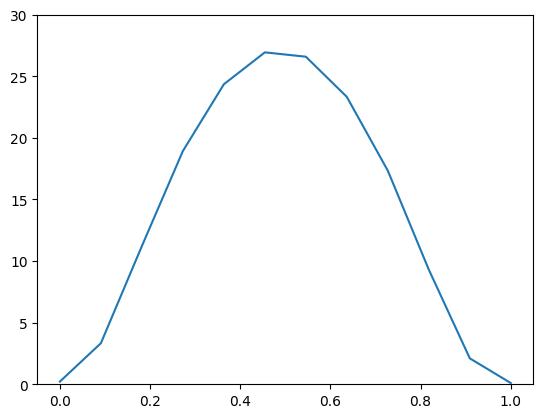

In [23]:
ts = torch.linspace(0,1, (12), device=device)[:, None]
losses = ts2loss(ts)
plt.plot(ts.flatten().cpu(), [l.cpu().item() for l in losses])
plt.ylim(0, 30)
plt.show()

In [24]:
cbs = 12

[000] 16.02907


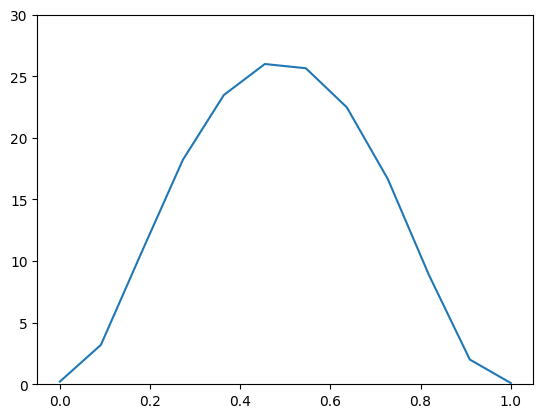

[001] 13.39539
[002] 12.35282
[003] 14.19304
[004] 11.45968
[005] 12.45533
[006] 13.61286
[007] 16.58305
[008] 11.89743
[009] 12.13244
[010] 11.61677
[011] 10.76884
[012] 8.64893
[013] 7.94053
[014] 5.45358
[015] 6.32237
[016] 10.13618
[017] 6.87970
[018] 8.84999
[019] 6.71759
[020] 5.53829
[021] 4.92985
[022] 6.02450
[023] 7.00679
[024] 5.94746
[025] 5.42199


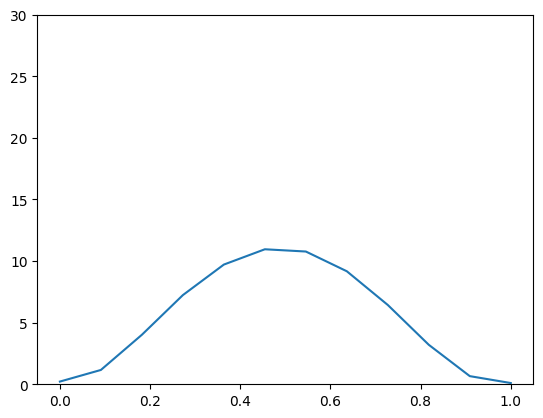

[026] 5.18974
[027] 6.17319
[028] 2.65406
[029] 5.90222
[030] 6.76738
[031] 5.96807
[032] 4.71104
[033] 4.73412
[034] 4.47450
[035] 3.78833
[036] 4.41967
[037] 5.73926
[038] 4.68463
[039] 3.47366
[040] 2.97067
[041] 4.21713
[042] 4.36136
[043] 4.46628
[044] 2.36598
[045] 2.38468
[046] 4.37115
[047] 4.78384
[048] 2.56350
[049] 4.21585
[050] 3.14375


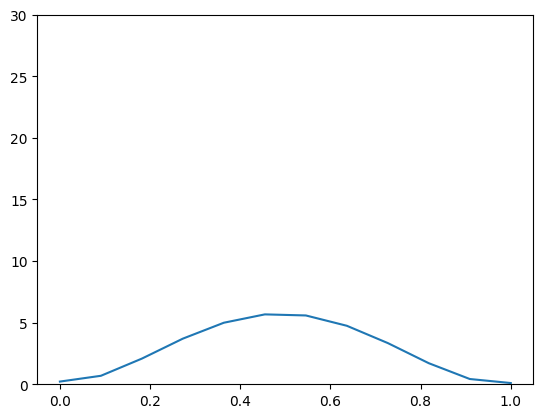

[051] 3.74788
[052] 2.62163
[053] 3.10045
[054] 2.78263
[055] 3.08444
[056] 2.68999
[057] 3.75748
[058] 2.07466
[059] 1.60389
[060] 3.08764
[061] 3.36706
[062] 2.17106
[063] 2.61161
[064] 2.70542
[065] 2.58051
[066] 3.02081
[067] 2.18119
[068] 2.24956
[069] 2.84376
[070] 2.69781
[071] 2.74607
[072] 1.79357
[073] 2.02397
[074] 2.86833
[075] 2.26774


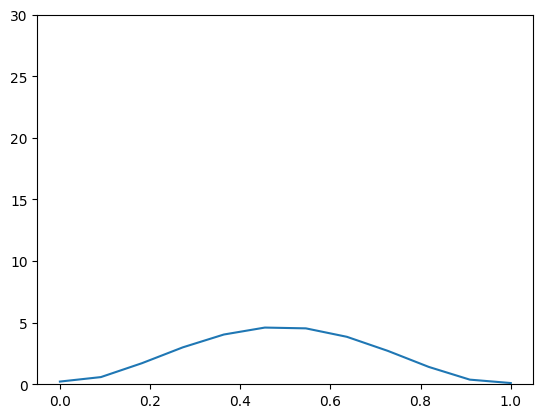

[076] 2.85742
[077] 2.07998
[078] 2.06730
[079] 1.99709
[080] 2.14784
[081] 2.25462
[082] 2.90208
[083] 2.88176
[084] 2.42554
[085] 2.21832
[086] 2.84118
[087] 1.60206
[088] 2.46510
[089] 2.53561
[090] 2.14019
[091] 1.93916
[092] 2.37555
[093] 2.71139
[094] 1.87360
[095] 1.98609
[096] 2.39558
[097] 2.78423
[098] 2.48916
[099] 2.38125
[100] 1.93430


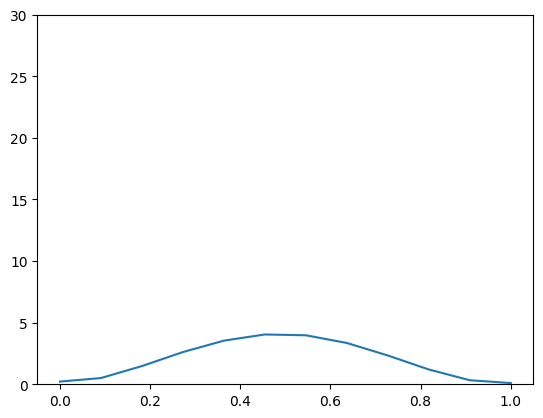

[101] 1.80463
[102] 2.58033
[103] 1.76831
[104] 1.08673
[105] 1.41739
[106] 2.51608
[107] 1.88627
[108] 1.85700
[109] 2.15371
[110] 1.26542
[111] 2.13149
[112] 2.21105
[113] 1.72398
[114] 1.68567
[115] 2.76325
[116] 2.40125
[117] 1.85651
[118] 2.28663
[119] 1.95063
[120] 2.68866
[121] 1.89540
[122] 1.75683
[123] 1.43911
[124] 1.59107
[125] 2.13338


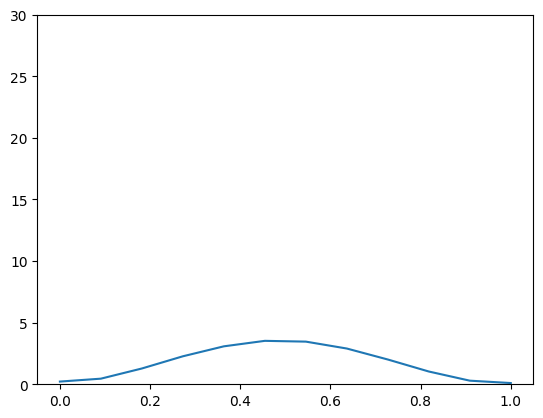

[126] 1.81331
[127] 1.54673
[128] 1.20556
[129] 2.21251
[130] 1.52999
[131] 1.85583
[132] 2.06491
[133] 1.37877
[134] 1.96326


Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/opt/conda/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/opt/conda/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/var/tmp/pymp-k7qfz14p'


[135] 1.48520
[136] 2.03839
[137] 2.01963
[138] 1.47396
[139] 1.33171
[140] 1.12739
[141] 1.92703
[142] 1.59532
[143] 1.44861
[144] 1.59828
[145] 1.59868
[146] 1.31461
[147] 1.47337
[148] 1.25670
[149] 0.80368
[150] 1.57028


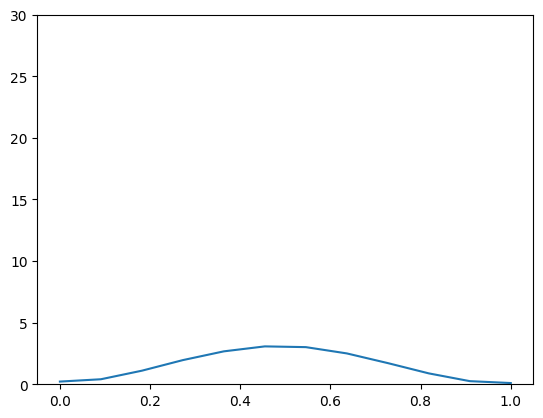

[151] 1.36386
[152] 1.09895
[153] 1.66730
[154] 1.97900
[155] 1.64917
[156] 1.43933
[157] 1.72862
[158] 1.34744
[159] 2.01167
[160] 1.43321
[161] 1.44339
[162] 1.84625
[163] 1.46832


In [ ]:
vis_loss_dynamics = []
for i in range(5000):
    ts = torch.rand(cbs, 1, device=device)
    ws = connectome.phi(ts)
    loss = 0
    for w in ws:
        loss = loss + loss_for_w(w)
    
    loss = loss / cbs
    print(f'[{i:03}] {loss:.5f}')
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 25 == 0:
        with torch.inference_mode():
            ts = torch.linspace(0,1, (12), device=device)[:, None]
            losses = ts2loss(ts)
            
            vis_loss_dynamics.append( (i, losses) )
            plt.plot(ts.flatten().cpu(), [l.cpu().item() for l in losses])
            plt.ylim(0, 30)
            plt.show()